### 데이터 전처리

In [2]:
import requests
import pandas as pd
import xml.etree.ElementTree as ET
from tqdm import tqdm

service_key = "vSkYEWotBgfYle/N78wp5dV3uoco5BGJywenZoRJWaGdnYtCB9EMBb3vjVzaXU19j2lfzM8M7Yz74saO86xJxw=="
rows_per_page = 100
total_pages = 30

all_data = []

for page in tqdm(range(1, total_pages + 1)):
    url = "http://apis.data.go.kr/6260000/BusanBIMS/busStopList"
    params = {
        "serviceKey": service_key,
        "numOfRows": rows_per_page,
        "pageNo": page
    }

    res = requests.get(url, params=params)
    root = ET.fromstring(res.content)

    items = root.find(".//items")
    if items is None:
        continue

    for item in items:
        try:
            bstopid = item.findtext("bstopid")
            bstopnm = item.findtext("bstopnm")
            gpsx = item.findtext("gpsx")
            gpsy = item.findtext("gpsy")
            all_data.append([bstopid, bstopnm, gpsx, gpsy])
        except:
            continue

df = pd.DataFrame(all_data, columns=["bstopid", "bstopnm", "lon", "lat"])
print("전체 정류장 수:", len(df))

100%|██████████| 30/30 [00:21<00:00,  1.43it/s]

전체 정류장 수: 3029


In [3]:
df.to_csv("busan_all_bus_stops.csv", index=False, encoding="utf-8-sig")
print("✅ 저장 완료: busan_all_bus_stops.csv")

✅ 저장 완료: busan_all_bus_stops.csv


In [4]:
df = pd.read_csv("busan_all_bus_stops.csv", encoding="utf-8-sig")
print(df.head())

     bstopid      bstopnm         lon        lat
0  167970102        영주삼거리  129.033322  35.115356
1  169310303        영주삼거리  129.033030  35.115283
2  167970301        시민아파트  129.031749  35.115140
3  167840102        시민아파트  129.032160  35.114921
4  167970302  중앙공원.민주공원입구  129.029762  35.114487


In [5]:
# 문자열로 들어온 좌표를 숫자형으로 변환
df["lon"] = pd.to_numeric(df["lon"], errors="coerce")
df["lat"] = pd.to_numeric(df["lat"], errors="coerce")

# 결측치 제거
df = df.dropna(subset=["lon", "lat"])
print("✅ 형변환 및 결측치 제거 완료")

✅ 형변환 및 결측치 제거 완료


In [6]:
df_unique = df.drop_duplicates(subset=["bstopnm", "lon", "lat"])
print("✅ 중복 제거 후 정류장 수:", len(df_unique))

✅ 중복 제거 후 정류장 수: 3000


In [4]:
import pandas as pd

file_path = '/Users/g.j.kim/Downloads/부산교통공사_도시철도역사정보_20210226.csv'

# UTF-16 인코딩의 탭 구분 파일 읽기
df = pd.read_csv(file_path, encoding='utf-16', sep='\t', engine='python')

# 데이터프레임 정보 출력
print(df.info())

# 상위 5개 행 출력
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   역번호      114 non-null    int64  
 1   역사명      114 non-null    object 
 2   노선번호     114 non-null    object 
 3   노선명      114 non-null    object 
 4   영문역사명    114 non-null    object 
 5   한자역사명    114 non-null    object 
 6   환승역구분    114 non-null    object 
 7   환승노선번호   12 non-null     object 
 8   환승노선명    12 non-null     object 
 9   역위도      114 non-null    float64
 10  역경도      114 non-null    float64
 11  운영기관명    114 non-null    object 
 12  역사도로명주소  114 non-null    object 
 13  역사전화번호   114 non-null    object 
 14  데이터기준일자  114 non-null    object 
dtypes: float64(2), int64(1), object(12)
memory usage: 13.5+ KB
None
   역번호      역사명   노선번호         노선명           영문역사명    한자역사명 환승역구분 환승노선번호  \
0   95  다대포해수욕장  S2601  부산도시철도 1호선   Dadaepo Beach  多大浦海水浴場   일반역    NaN   
1   96    다대포항역  S2601  부산도시

In [7]:
from sklearn.cluster import KMeans

coords = df_unique[["lat", "lon"]]
kmeans = KMeans(n_clusters=5, random_state=42)
df_unique["cluster"] = kmeans.fit_predict(coords)

print(df_unique.head())

     bstopid      bstopnm         lon        lat  cluster
0  167970102        영주삼거리  129.033322  35.115356        2
1  169310303        영주삼거리  129.033030  35.115283        2
2  167970301        시민아파트  129.031749  35.115140        2
3  167840102        시민아파트  129.032160  35.114921        2
4  167970302  중앙공원.민주공원입구  129.029762  35.114487        2


/var/folders/wy/8fvw_q1955v9yxg3h73mwc1c0000gn/T/ipykernel_87728/1221257121.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique["cluster"] = kmeans.fit_predict(coords)


In [8]:
import folium

# 지도 중심을 대충 부산 중간쯤으로
map_center = [df_unique["lat"].mean(), df_unique["lon"].mean()]
m = folium.Map(location=map_center, zoom_start=12)

for _, row in df_unique.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=3,
        popup=row["bstopnm"],
        color="blue",
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

m.save("busan_busstop_map.html")
print("✅ 지도 저장 완료 (busan_busstop_map.html)")

✅ 지도 저장 완료 (busan_busstop_map.html)


In [9]:
df_unique.to_csv("busan_cleaned_bus_stops.csv", index=False, encoding="utf-8-sig")
print("✅ 저장 완료: busan_cleaned_bus_stops.csv")

✅ 저장 완료: busan_cleaned_bus_stops.csv


In [10]:
# 좌표를 숫자로 변환 (오류값은 NaN 처리)
df["lon"] = pd.to_numeric(df["lon"], errors="coerce")
df["lat"] = pd.to_numeric(df["lat"], errors="coerce")

# 결측 제거
df = df.dropna(subset=["lon", "lat"]).reset_index(drop=True)

In [11]:
from sklearn.cluster import KMeans

# 클러스터링 대상 좌표
coords = df[["lat", "lon"]]

# 클러스터 수: 예시로 5개 (원하면 elbow method로 최적화 가능)
kmeans = KMeans(n_clusters=5, random_state=42)
df["cluster"] = kmeans.fit_predict(coords)

/var/folders/wy/8fvw_q1955v9yxg3h73mwc1c0000gn/T/ipykernel_87728/2207268340.py:14: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wy/8fvw_q1955v9yxg3h73mwc1c0000gn/T/ipykernel_87728/2207268340.py:14: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wy/8fvw_q1955v9yxg3h73mwc1c0000gn/T/ipykernel_87728/2207268340.py:14: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wy/8fvw_q1955v9yxg3h73mwc1c0000gn/T/ipykernel_87728/2207268340.py:14: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wy/8fvw_q1955v9yxg3h73mwc1c0000gn/T/ipykernel_87728/2207268340.py:14: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wy/8fvw_q1955v9yxg3h73mwc1c0000gn/T/ipyker

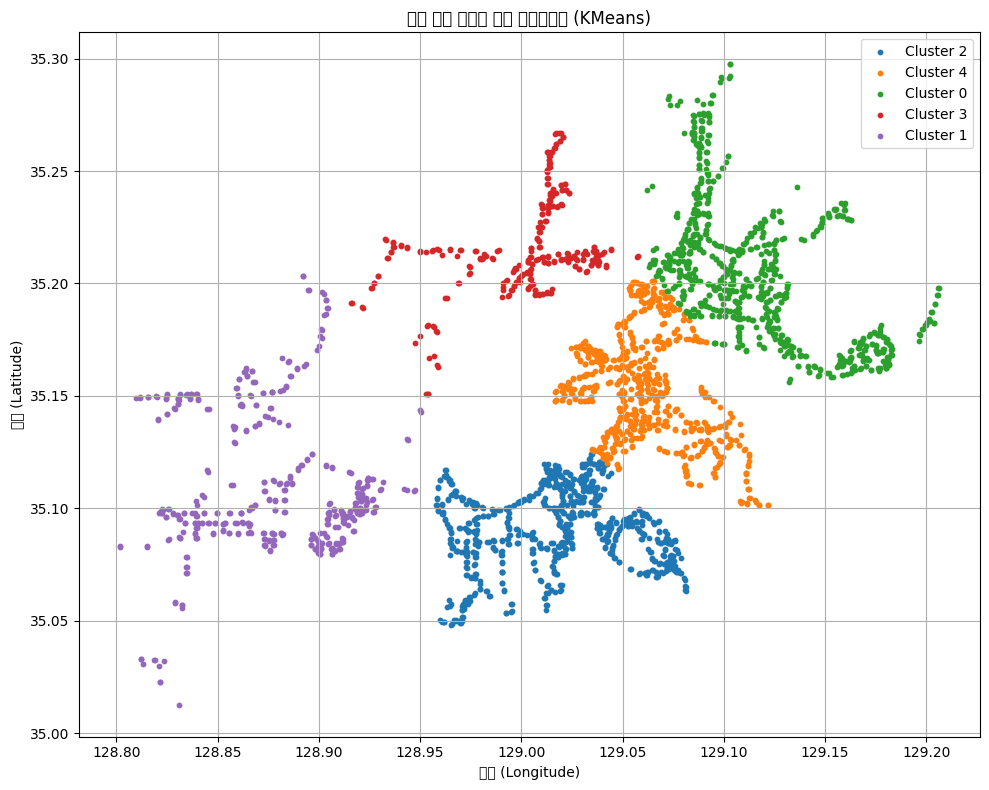

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

for cluster_num in df["cluster"].unique():
    cluster_data = df[df["cluster"] == cluster_num]
    plt.scatter(cluster_data["lon"], cluster_data["lat"], label=f"Cluster {cluster_num}", s=10)

plt.title("부산 버스 정류장 위치 클러스터링 (KMeans)")
plt.xlabel("경도 (Longitude)")
plt.ylabel("위도 (Latitude)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
print(df["cluster"].value_counts())

cluster
0    827
2    766
4    718
1    434
3    284
Name: count, dtype: int64


In [32]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


### 벡스코 반경 내 정류장 수 

In [36]:
import requests
import pandas as pd
from tqdm import tqdm
import xml.etree.ElementTree as ET

service_key = "vSkYEWotBgfYle/N78wp5dV3uoco5BGJywenZoRJWaGdnYtCB9EMBb3vjVzaXU19j2lfzM8M7Yz74saO86xJxw=="
rows_per_page = 100
total_pages = 30  # 우선 30페이지까지만

all_data = []

for page in tqdm(range(1, total_pages + 1)):
    url = "http://apis.data.go.kr/6260000/BusanBIMS/busStopList"
    params = {
        "serviceKey": service_key,
        "numOfRows": rows_per_page,
        "pageNo": page
    }

    res = requests.get(url, params=params)
    root = ET.fromstring(res.content)

    items = root.find(".//items")
    if items is None:
        continue

    for item in items:
        try:
            bstopid = item.findtext("bstopid")
            bstopnm = item.findtext("bstopnm")
            gpsx = item.findtext("gpsx")
            gpsy = item.findtext("gpsy")
            all_data.append([bstopid, bstopnm, gpsx, gpsy])
        except:
            continue

df = pd.DataFrame(all_data, columns=["bstopid", "bstopnm", "lon", "lat"])
print("전체 정류장 수:", len(df))

100%|██████████| 30/30 [00:20<00:00,  1.43it/s]

전체 정류장 수: 3029


In [37]:
from geopy.distance import geodesic

# 벡스코 역 기준 좌표
bexco_coord = (35.16834, 129.1368)

# 거리 계산
df["distance_from_bexco"] = df.apply(lambda row: geodesic((float(row["lat"]), float(row["lon"])), bexco_coord).meters, axis=1)
df_bexco_near = df[df["distance_from_bexco"] <= 500]

print("✅ 벡스코 반경 내 정류장 수:", len(df_bexco_near))
print(df_bexco_near[["bstopnm", "lon", "lat", "distance_from_bexco"]])

✅ 벡스코 반경 내 정류장 수: 13
              bstopnm               lon              lat  distance_from_bexco
1642        센텀시티역.벡스코  129.133255322926  35.169517403775           348.340013
1742        센텀시티역.벡스코  129.132774068402  35.169742383607           398.398809
1764       롯데백화점센텀시티점  129.131784305782  35.169673237343           480.274658
1799              벡스코  129.133947317281  35.167539789811           274.628382
1800              벡스코  129.133706773686  35.167363799445           301.892720
1801       롯데백화점센텀시티점  129.132035677781  35.169979525655           470.603031
1837  벡스코역.올림픽교차로환승센터   129.13740056272  35.167820959936            79.431325
1866          동해선벡스코역  129.134082572524  35.171664655398           444.222212
1868        벡스코.시립미술관  129.136989719974    35.1705725582           248.290501
1869       올림픽교차로환승센터  129.138093271854  35.168270931997           118.067090
1870           올림픽교차로  129.140478516907  35.167600030814           345.026446
1871           올림픽교차로  129.140006438138  35

In [39]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [41]:
import folium

# 벡스코 중심
bexco_lat, bexco_lon = 35.16834, 129.1368
m = folium.Map(location=[bexco_lat, bexco_lon], zoom_start=16)

# 벡스코 위치 마커
folium.Marker([bexco_lat, bexco_lon], tooltip="벡스코", icon=folium.Icon(color="red")).add_to(m)

# 주변 정류장 마커
for _, row in df_bexco_near.iterrows():
    folium.Marker(
        [float(row["lat"]), float(row["lon"])],
        tooltip=f"{row['bstopnm']} ({int(row['distance_from_bexco'])}m)"
    ).add_to(m)

m

### 벡스코 반경 500m내 정류장

In [ ]:
import requests
from tqdm import tqdm
import time


df_bexco_near = df_bexco_near.reset_index(drop=True)

service_key = "vSkYEWotBgfYle/N78wp5dV3uoco5BGJywenZoRJWaGdnYtCB9EMBb3vjVzaXU19j2lfzM8M7Yz74saO86xJxw=="

In [44]:
def get_bus_arrival_info(bstopid, service_key):
    url = "http://apis.data.go.kr/6260000/BusanBIMS/busArrivalList"
    params = {
        "serviceKey": service_key,
        "bstopid": bstopid,
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.text
    else:
        return None

In [ ]:
arrival_results = []

for _, row in tqdm(df_bexco_near.iterrows(), total=len(df_bexco_near)):
    bstopid = row["bstopid"]
    raw_xml = get_bus_arrival_info(bstopid, service_key)
    arrival_results.append({
        "bstopid": bstopid,
        "bstopnm": row["bstopnm"],
        "response": raw_xml
    })
    time.sleep(0.2)  

100%|██████████| 13/13 [00:44<00:00,  3.43s/it]


In [67]:
for item in arrival_results[:3]:
    print(f"\n🚌 정류장: {item['bstopnm']} ({item['bstopid']})")



🚌 정류장: 센텀시티역.벡스코 (185130101)

🚌 정류장: 센텀시티역.벡스코 (185100201)

🚌 정류장: 롯데백화점센텀시티점 (184300201)


In [69]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48289 (\N{HANGUL SYLLABLE BEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_fig

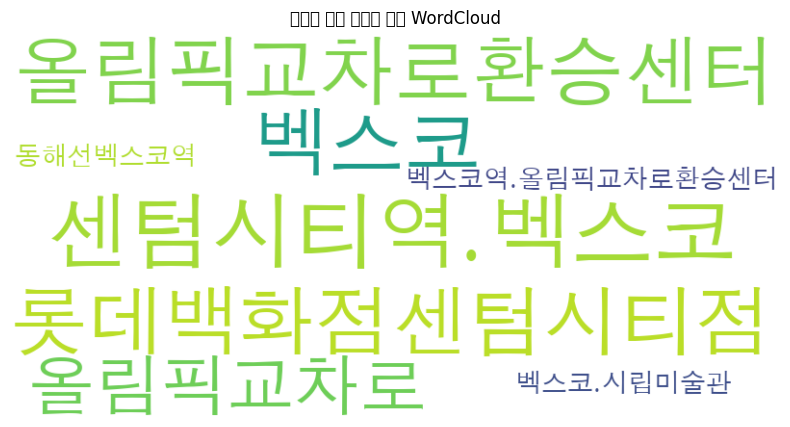

In [70]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 1. 정류장 이름 모으기
names = df_bexco_near['bstopnm'].tolist()

# 2. 띄어쓰기 기준으로 단어 나누고 빈도수 세기
all_words = ' '.join(names).split()
word_counts = Counter(all_words)

# 3. 워드클라우드
wc = WordCloud(font_path="/System/Library/Fonts/Supplemental/AppleGothic.ttf", background_color='white', width=800, height=400)
wc.generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("벡스코 주변 정류장 이름 WordCloud")
plt.show()

### 정류장 위치(위도, 경도)기준으로 공간적으로 가까운 정류장 클러스터링

/var/folders/wy/8fvw_q1955v9yxg3h73mwc1c0000gn/T/ipykernel_84143/2274624793.py:24: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wy/8fvw_q1955v9yxg3h73mwc1c0000gn/T/ipykernel_84143/2274624793.py:24: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wy/8fvw_q1955v9yxg3h73mwc1c0000gn/T/ipykernel_84143/2274624793.py:24: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wy/8fvw_q1955v9yxg3h73mwc1c0000gn/T/ipykernel_84143/2274624793.py:24: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wy/8fvw_q1955v9yxg3h73mwc1c0000gn/T/ipykernel_84143/2274624793.py:24: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wy/8fvw_q1955v9yxg3h73mwc1c0000gn/T/ipy

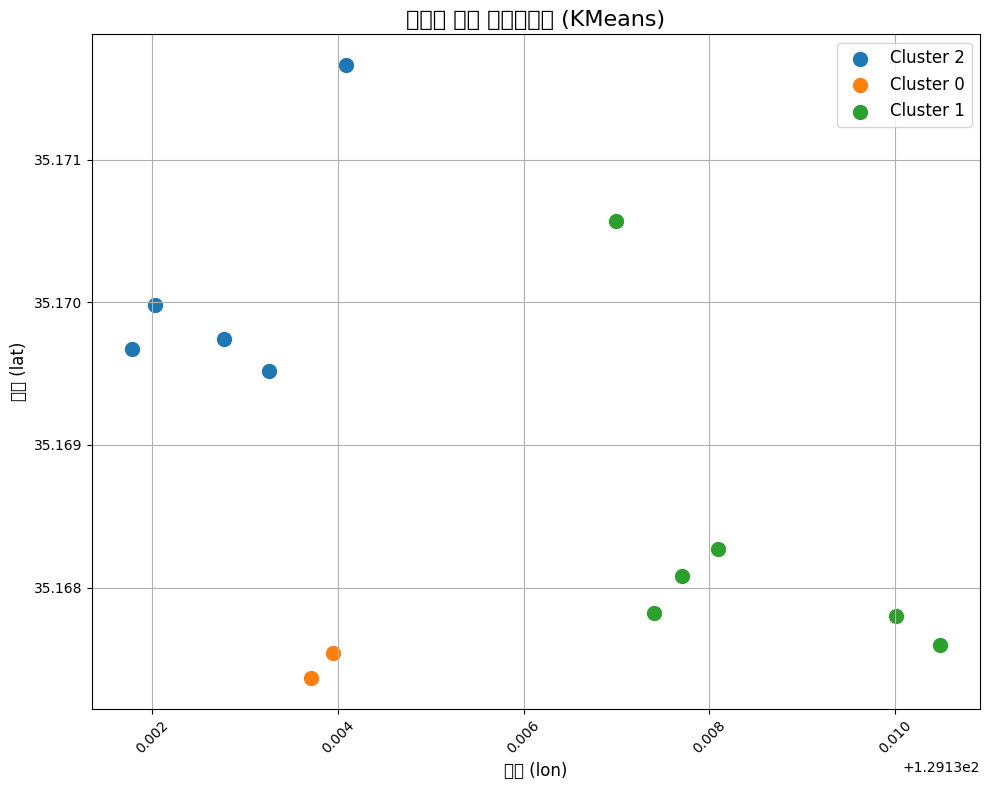

In [75]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 클러스터링 대상 좌표
coords = df_bexco_near[['lat', 'lon']]

# 클러스터 수 지정
kmeans = KMeans(n_clusters=3, random_state=42)
df_bexco_near['cluster'] = kmeans.fit_predict(coords)

# 시각화
plt.figure(figsize=(10, 8))
for c in df_bexco_near['cluster'].unique():
    cluster_data = df_bexco_near[df_bexco_near['cluster'] == c]
    plt.scatter(cluster_data['lon'], cluster_data['lat'], s=100, label=f'Cluster {c}')  # s=마커 크기

plt.title("정류장 위치 클러스터링 (KMeans)", fontsize=16)
plt.xlabel("경도 (lon)", fontsize=12)
plt.ylabel("위도 (lat)", fontsize=12)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
print(df_bexco_near['cluster'].value_counts())

cluster
1    6
2    5
0    2
Name: count, dtype: int64
